In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smt

from Bio import SeqIO
from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import pearsonr

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":10,"axes.titlesize":10,
                       "axes.labelsize":10, 'axes.linewidth':0.5,
                       "legend.fontsize":10, "xtick.labelsize":10,
                       "ytick.labelsize":10, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 10

sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [4]:
chip_seqs_f = "../../../../data/external/chip/TBX5_ChIP_peaks.centered.fasta"
genre_seqs_f = "../../../../data/external/chip/TBX5_ChIP.genre_background.fasta"
closest_tss_f = "../../../../data/external/chip/TBX5_ChIP_peaks.closest_pc_tss.txt"
upbm_f = "../../../../data/processed/pbms/TBX5kfit_dat.csv"

In [5]:
joung_ref_f = "../../../../data/external/joung_files/GE.TFORF1983-TBX5_vs_cellHarmony-Reference.txt"
joung_alt_f = "../../../../data/external/joung_files/GE.TFORF1982-TBX5_vs_cellHarmony-Reference.txt"

In [6]:
motif = "AGGTGT"
motif_rc = "ACACCT"

sp_motif = "ACGTGT"
sp_motif_rc = "ACACGT"

## 1. import data

In [7]:
upbm = pd.read_table(upbm_f, sep=",")
upbm.head()

,seq,cname,affinityEstimate,affinityVariance,contrastDifference,contrastAverage,contrastVariance,contains_any_motif
0,AAAAAAAA,TBX5C05-REF,10.028611,0.004803,NaN,NaN,NaN,other k-mer
1,AAAAAAAA,TBX5A05,9.931881,0.003412,-0.096730,9.980246,0.003536,other k-mer
2,AAAAAAAA,TBX5B05,9.903240,0.006690,-0.125371,9.965926,0.003227,other k-mer
3,AAAAAAAC,TBX5C05-REF,9.956585,0.001912,NaN,NaN,NaN,other k-mer
4,AAAAAAAC,TBX5A05,9.957827,0.003953,0.001242,9.957206,0.003823,other k-mer


In [8]:
names = []
seqs = []

for record in SeqIO.parse(chip_seqs_f, "fasta"):
    names.append(record.id)
    seqs.append(str(record.seq))

In [9]:
chip = pd.DataFrame([names, seqs]).T
chip.columns = ["id", "seq"]

In [10]:
chip.id.iloc[0]

'ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%20cardiac%20cells);Title=GSM2183992:%20TBX5%3B%20Homo%20sapiens%3B%20ChIP-Seq;Cell%20group=Pluripotent%20stem%20cell;<br>source_name=blood;cell%20type=hiPSCs-CMs;Stage=day%2030;replicate=1;chip-seq%20antibody=Sigma,%20SAB1411331;::chr1:629629-630029'

In [11]:
# parse id
chip["sr"] = chip["id"].str.extract(r'ID=([A-Z0-9]*)', expand=True)[0]
chip["name"] = chip["id"].str.extract(r'Name=([A-Za-z0-9\%\@\(\)]*);', expand=True)[0]
chip["name"] = chip["name"].str.replace("%20", " ")
chip["title"] = chip["id"].str.extract(r'Title=([A-Za-z0-9\%\:\-\.]*);', expand=True)[0]
chip["title"] = chip["title"].str.replace(r"%20", " ")
chip["title"] = chip["title"].str.replace(r"%3B", " ")
chip["cell"] = chip["id"].str.extract(r'Cell\%20group=([A-Za-z0-9\%\:\-\.]*);', expand=True)[0]
chip["cell"] = chip["cell"].str.replace(r"%20", " ")
chip["source_name"] = chip["id"].str.extract(r'source_name=([A-Za-z0-9\%\:\-\.\(\)]*);', expand=True)[0]
chip["source_name"] = chip["source_name"].str.replace(r"%20", " ")
chip["cell_type"] = chip["id"].str.extract(r'cell\%20type=([A-Za-z0-9\%\:\-\.]*);', expand=True)[0]
chip["cell_type"] = chip["cell_type"].str.replace(r"%20", " ")
chip["stage"] = chip["id"].str.extract(r'tage=([A-Za-z0-9\%\:\-\.]*);', expand=True)[0]
chip["stage"] = chip["stage"].str.replace(r"%20", " ")
chip["rep"] = chip["id"].str.extract(r'replicate=([0-9]*);', expand=True)[0]
chip["antibody"] = chip["id"].str.extract(r'antibody=([A-Za-z0-9\%\:\-\.\,\(\)]*);', expand=True)[0]
chip["antibody"] = chip["antibody"].str.replace(r"%20", " ")
chip["locs"] = chip["id"].str.extract(r'\;\:\:(chr[0-9XY]*\:\d*\-\d*)*', expand=True)[0]
chip[["sr", "title", "cell", "cell_type", "source_name", "antibody"]].drop_duplicates()

,sr,title,cell,cell_type,source_name,antibody
0,SRX1815017,GSM2183992: TBX5 Homo sapiens ChIP-Seq,Pluripotent stem cell,hiPSCs-CMs,blood,"Sigma, SAB1411331"
1313,SRX2023705,GSM2279963: 1 8 Tbx5 chip Homo sapiens ChIP-Seq,Pluripotent stem cell,iPS-derived cardiomyocytes,purified cardiomyocyte WT,TBX5 (sc17866)
1315,SRX2023713,GSM2279971: 5 6 Tbx5 chip Homo sapiens ChIP-Seq,Pluripotent stem cell,iPS-derived cardiomyocytes,purified cardiomyocyte WT,TBX5 (sc17866)
2509,SRX2023721,GSM2279985: H7 Tbx5 chip Homo sapiens ChIP-Seq,Pluripotent stem cell,iPS-derived cardiomyocytes,purified cardiomyocyte WT,TBX5 (sc17866)
3528,SRX9284026,GSM4829315: tbx5 wt.1 180417 ChIPseq rep1 Hom...,Pluripotent stem cell,hiPSC cardiomyocyte,WT hiPSC cardiomyocyte differentiation day 6 (...,TBX5 (C-20) antibody
3909,SRX9284039,GSM4829312: tbx5 wt11.1 171214 ChIPseq rep 1 ...,Pluripotent stem cell,hiPSC cardiomyocyte,WT hiPSC cardiomyocyte differentiation day 6 (...,TBX5 (C-20) antibody


In [12]:
names = []
seqs = []

for record in SeqIO.parse(genre_seqs_f, "fasta"):
    names.append(record.id)
    seqs.append(str(record.seq))

In [13]:
genre = pd.DataFrame([names, seqs]).T
genre.columns = ["id", "seq"]
genre.head()

,id,seq
0,::chrX:15331514-15331664,AGAGCATCATGGGCCATAGCAGAAAAAGAACTATGTGAATGGATTA...
1,::chr1:244420992-244421142,ATTTTGAAACTTGCATCAGTGATTCTCAAAATGTGGTGAGGGCCAC...
2,::chr19:6211776-6211926,AGCGTCCTGGCCCTGGAAGAGTGGGCCGGGAAGGAGGACCGGCTTG...
3,::chr2:240345744-240345894,GCCTCTGACAGCTTTGCAGCACCCATTAGCGCTCCTCGCCTTGTGA...
4,::chr8:72660262-72660412,GGTTGCAAGTGTCTGCCAGCGCATGGAGCCCCGGGAAGTGCTTTGG...


In [14]:
closest_tss = pd.read_table(closest_tss_f, header=None)
closest_tss.columns = ["chr", "start", "end", "id", "len", "strand", "score", "x", "chr_tss", "start_tss",
                       "end_tss", "tx_tss", "score_tss", "strand_tss", "dist"]
closest_tss.head()

,chr,start,end,id,len,strand,score,x,chr_tss,start_tss,end_tss,tx_tss,score_tss,strand_tss,dist
0,chr1,629629,630029,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,1000,.,18.38,147,chr1,686673,686674,OR4F16-201,0,-,56645
1,chr1,633835,634235,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,1000,.,32.85,164,chr1,686673,686674,OR4F16-201,0,-,52439
2,chr1,1625064,1625464,ID=SRX2023713;Name=TBX5%20(@%20iPSC%20derived%...,689,.,0.83,95,chr1,1625086,1625087,MIB2-223,0,+,0
3,chr1,1625100,1625500,ID=SRX2023721;Name=TBX5%20(@%20iPSC%20derived%...,625,.,0.90,94,chr1,1625086,1625087,MIB2-223,0,+,-14
4,chr1,1625125,1625525,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,1000,.,6.09,141,chr1,1625086,1625087,MIB2-223,0,+,-39


In [15]:
joung_ref = pd.read_table(joung_ref_f, delim_whitespace=True)
print(len(joung_ref))
joung_alt = pd.read_table(joung_alt_f, delim_whitespace=True)
print(len(joung_alt))
joung_ref.head()

179
617


,GeneID,SystemCode,LogFold,rawp,adjp,Symbol,avg-TFORF1983-TBX5,avg-cellHarmony-Reference
0,ENSG00000089225,En,0.461425,8.885083e-126,2.588314e-121,TBX5,0.463025,0.001599
1,ENSG00000197061,En,-1.311618,1.824374e-29,1.398575e-26,HIST1H4C,2.028954,3.340572
2,ENSG00000104432,En,0.497717,2.217831e-23,1.292153e-20,IL7,0.518219,0.020502
3,LOC101928553,Sy,0.291844,8.135882e-19,3.485388e-16,LOC101928553,0.299776,0.007932
4,ENSG00000137309,En,-1.283155,1.113636e-15,3.772246e-13,HMGA1,1.781623,3.064778


## 2. filter ChIP

don't use any mut/WT data (some of these are from mutant GATA4, for example, which can disrupt TBX5 recruitment: https://pubmed.ncbi.nlm.nih.gov/27984724/)

antibody antigens:
- Sigma SAB1411331 immunogen is FL protein (https://www.sigmaaldrich.com/US/en/product/sigma/sab1411331) -- will recognize all (?)
- Santa Cruz sc17866/C-20 immunogen is C-terminus (https://datasheets.scbt.com/sc-17866.pdf) -- will recognize REF and B05 (but not A05)

NOTE: probably should make sure these peaks don't overlap at some point

In [16]:
studies_to_use = ["SRX1815017", "SRX2023713", "SRX9284026", "SRX2023721", "SRX9284039", "SRX2023705"]
chip_filt = chip[chip["sr"].isin(studies_to_use)]
len(chip_filt)

3981

## 3. center ChIP and background peaks to the middle 200

In [17]:
chip_filt["peak_length"] = chip_filt.seq.str.len()
chip_filt.peak_length.min()

400

In [18]:
centered_peak_len = 200
int(centered_peak_len/2)

100

In [19]:
def get_center_seq(row):
    seq_len = row.peak_length
    midpoint = int(np.floor(seq_len/2))
    centered_seq = row.seq[midpoint-int(centered_peak_len/2):midpoint+int(centered_peak_len/2)]
    return centered_seq

chip_filt["seq_cent"] = chip_filt.apply(get_center_seq, axis=1)
chip_filt["center_length"] = chip_filt.seq_cent.str.len()
chip_filt.head()

,id,seq,sr,name,title,cell,source_name,cell_type,stage,rep,antibody,locs,peak_length,seq_cent,center_length
0,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,TCCCGTACTAATTAATCCCCTGGCCCAACCCGTCATCTACTCTACC...,SRX1815017,TBX5 (@ iPSC derived cardiac cells),GSM2183992: TBX5 Homo sapiens ChIP-Seq,Pluripotent stem cell,blood,hiPSCs-CMs,day 30,1,"Sigma, SAB1411331",chr1:629629-630029,400,GTAGGCCTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCA...,200
1,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,ATGACTAATCCAACTAACCTCAAAACAAATGATAGCCATACACAAC...,SRX1815017,TBX5 (@ iPSC derived cardiac cells),GSM2183992: TBX5 Homo sapiens ChIP-Seq,Pluripotent stem cell,blood,hiPSCs-CMs,day 30,1,"Sigma, SAB1411331",chr1:633835-634235,400,ACAACTAACCTCCTCGGACTCCTGCCTCACTCATTTACACCAACCA...,200
2,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,TCAAGTGTGTGGGCGAGGCAGCGGGCGGCTTCTACTACAAGGACCA...,SRX1815017,TBX5 (@ iPSC derived cardiac cells),GSM2183992: TBX5 Homo sapiens ChIP-Seq,Pluripotent stem cell,blood,hiPSCs-CMs,day 30,1,"Sigma, SAB1411331",chr1:1625125-1625525,400,TGGCTGAAGTCCCAGAGGGGAGGGGCCGCTGCCTGAGGCCTGGTCT...,200
3,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,GACATTTGTGGTCAGATAATTCTGTTGTGGGGAGCTGTTCTGTGCA...,SRX1815017,TBX5 (@ iPSC derived cardiac cells),GSM2183992: TBX5 Homo sapiens ChIP-Seq,Pluripotent stem cell,blood,hiPSCs-CMs,day 30,1,"Sigma, SAB1411331",chr1:3328265-3328665,400,AGAGCTATCTCCTTGGTCGTGGGCCAGGGGCTTTGATGACAGGGCC...,200
4,ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%...,AGCCAGGAGTCAATGCATTTCTGCACGATTTTGTCAGCAACAAACC...,SRX1815017,TBX5 (@ iPSC derived cardiac cells),GSM2183992: TBX5 Homo sapiens ChIP-Seq,Pluripotent stem cell,blood,hiPSCs-CMs,day 30,1,"Sigma, SAB1411331",chr1:3349101-3349501,400,GGGCGCAGCATTCCTGGGCCTGCTCTCTGGCTCCCAGTGAGGGTCC...,200


## 4. plot distribution of k-mers

In [20]:
def get_kmer_ocurrences(row, kmer, kmer_rc):
    kmer_oc = [m.start() for m in re.finditer('(?=%s)' % kmer, row.seq_cent)]
    kmer_rc_oc = [m.start() for m in re.finditer('(?=%s)' % kmer_rc, row.seq_cent)]
    
    kmer_arr = np.zeros(centered_peak_len)
    for oc in kmer_oc:
        kmer_arr[oc:oc+len(kmer)] += 1
    for oc in kmer_rc_oc:
        kmer_arr[oc:oc+len(kmer_rc)] += 1
    
    return kmer_arr

In [21]:
chip_filt["motif_arr"] = chip_filt.apply(get_kmer_ocurrences, kmer=motif, kmer_rc=motif_rc, axis=1)
chip_filt["sp_motif_arr"] = chip_filt.apply(get_kmer_ocurrences, kmer=sp_motif, kmer_rc=sp_motif_rc, axis=1)
chip_filt["hd_arr"] = chip_filt.apply(get_kmer_ocurrences, kmer="TAATTA", kmer_rc="TAATTA", axis=1)

In [22]:
m = np.sum(np.array(chip_filt["motif_arr"].tolist()), axis=0)
sm = np.sum(np.array(chip_filt["sp_motif_arr"].tolist()), axis=0)
h = np.sum(np.array(chip_filt["hd_arr"].tolist()), axis=0)

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [24]:
m_av = moving_average(m, 8)
sm_av = moving_average(sm, 8)
h_av = moving_average(h, 8)

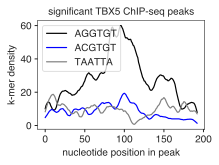

In [25]:
fig = plt.figure(figsize=(3, 2))

plt.plot(m_av, color="black", label=motif)
plt.plot(sm_av, color="blue", label=sp_motif)
plt.plot(h_av, color="grey", label="TAATTA")

plt.xlabel("nucleotide position in peak")
plt.ylabel("k-mer density")
plt.title("significant TBX5 ChIP-seq peaks")
#plt.ylim((-0.5, 22))

plt.legend(loc=2)

## 5. include GENRE bg

In [26]:
genre["peak_length"] = genre.seq.str.len()
genre.peak_length.value_counts()

150    3981
Name: peak_length, dtype: int64

In [27]:
genre.reset_index(inplace=True)
genre["peak_id"] = genre["index"]
chip_filt.reset_index(inplace=True)
chip_filt["peak_id"] = chip_filt["index"]

In [28]:
# peaks already centered
genre["seq_cent"] = genre["seq"]

In [29]:
genre["motif_arr"] = genre.apply(get_kmer_ocurrences, kmer=motif, kmer_rc=motif_rc, axis=1)
genre["sp_motif_arr"] = genre.apply(get_kmer_ocurrences, kmer=sp_motif, kmer_rc=sp_motif_rc, axis=1)
genre["hd_arr"] = genre.apply(get_kmer_ocurrences, kmer="TAATTA", kmer_rc="TAATTA", axis=1)

In [30]:
m_g = np.sum(np.array(genre["motif_arr"].tolist()), axis=0)
sm_g = np.sum(np.array(genre["sp_motif_arr"].tolist()), axis=0)
h_g = np.sum(np.array(genre["hd_arr"].tolist()), axis=0)

In [31]:
m_g_av = moving_average(m_g, 8)
sm_g_av = moving_average(sm_g, 8)
h_g_av = moving_average(h_g, 8)

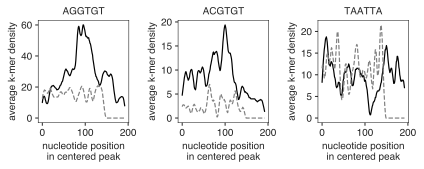

In [32]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 2.5))

i = 0
for fg_arr, bg_arr, kmer in zip([m_av, sm_av, h_av], [m_g_av, sm_g_av, h_g_av], 
                                 [motif, sp_motif, "TAATTA"]):
    
    ax = axarr[i]
    
    ax.plot(fg_arr, label="%s foreground" % kmer, color="black")
    ax.plot(bg_arr, linestyle="dashed", label="%s background" % kmer, color="grey")

    ax.set_xlabel("nucleotide position\nin centered peak")
    ax.set_ylabel("average k-mer density")
    ax.set_title(kmer)
    i += 1
    
plt.tight_layout()
fig.savefig("../../../../figures/TBX5_chip_density.pdf", dpi="figure", bbox_inches="tight")

## 6. fisher test for k-mer occurrence v background

In [33]:
def has_motif(row, col):
    arr = row[col]
    arr_sum = np.sum(arr)
    if arr_sum > 0:
        return 1
    else:
        return 0
    
chip_filt["has_motif"] = chip_filt.apply(has_motif, col="motif_arr", axis=1)
chip_filt["has_sp_motif"] = chip_filt.apply(has_motif, col="sp_motif_arr", axis=1)
chip_filt["has_hd"] = chip_filt.apply(has_motif, col="hd_arr", axis=1)

In [34]:
genre["has_motif"] = genre.apply(has_motif, col="motif_arr", axis=1)
genre["has_sp_motif"] = genre.apply(has_motif, col="sp_motif_arr", axis=1)
genre["has_hd"] = genre.apply(has_motif, col="hd_arr", axis=1)

In [35]:
motif_tab = np.zeros((2, 2))
sp_motif_tab = np.zeros((2, 2))
hd_tab = np.zeros((2, 2))  

In [36]:
n_m_fore = len(chip_filt[chip_filt["has_motif"] == 1])
n_nom_fore = len(chip_filt[chip_filt["has_motif"] == 0])

n_m_bg = len(genre[genre["has_motif"] == 1])
n_nom_bg = len(genre[genre["has_motif"] == 0])

motif_tab[0, 0] = n_m_fore
motif_tab[0, 1] = n_nom_fore
motif_tab[1, 0] = n_m_bg
motif_tab[1, 1] = n_nom_bg

fisher_exact(motif_tab)

(2.6373616716115698, 7.052505229941631e-50)

In [37]:
motif_tab

array([[ 829., 3152.],
       [ 361., 3620.]])

In [38]:
n_m_fore = len(chip_filt[chip_filt["has_sp_motif"] == 1])
n_nom_fore = len(chip_filt[chip_filt["has_sp_motif"] == 0])

n_m_bg = len(genre[genre["has_sp_motif"] == 1])
n_nom_bg = len(genre[genre["has_sp_motif"] == 0])

sp_motif_tab[0, 0] = n_m_fore
sp_motif_tab[0, 1] = n_nom_fore
sp_motif_tab[1, 0] = n_m_bg
sp_motif_tab[1, 1] = n_nom_bg

fisher_exact(sp_motif_tab)

(3.972080120129292, 3.652682265519834e-26)

In [39]:
sp_motif_tab

array([[ 239., 3742.],
       [  63., 3918.]])

In [40]:
n_m_fore = len(chip_filt[chip_filt["has_hd"] == 1])
n_nom_fore = len(chip_filt[chip_filt["has_hd"] == 0])

n_m_bg = len(genre[genre["has_hd"] == 1])
n_nom_bg = len(genre[genre["has_hd"] == 0])

hd_tab[0, 0] = n_m_fore
hd_tab[0, 1] = n_nom_fore
hd_tab[1, 0] = n_m_bg
hd_tab[1, 1] = n_nom_bg

fisher_exact(hd_tab)

(1.113040070873654, 0.40312780240114915)

In [41]:
hd_tab

array([[ 153., 3828.],
       [ 138., 3843.]])

In [42]:
motif_df = pd.DataFrame(motif_tab)
motif_df.index = ["foreground", "background"]
motif_df.columns = ["%s" % motif, "no %s" % motif]
motif_df.reset_index(inplace=True)
motif_m = pd.melt(motif_df, id_vars="index")

sp_motif_df = pd.DataFrame(sp_motif_tab)
sp_motif_df.index = ["foreground", "background"]
sp_motif_df.columns = ["%s" % sp_motif, "no %s" % sp_motif]
sp_motif_df.reset_index(inplace=True)
sp_motif_m = pd.melt(sp_motif_df, id_vars="index")
motif_m = motif_m.append(sp_motif_m)

hd_motif_df = pd.DataFrame(hd_tab)
hd_motif_df.index = ["foreground", "background"]
hd_motif_df.columns = ["TAATTA", "no TAATTA"]
hd_motif_df.reset_index(inplace=True)
hd_motif_m = pd.melt(hd_motif_df, id_vars="index")
motif_m = motif_m.append(hd_motif_m)

motif_m["perc"] = motif_m["value"]/len(chip_filt)

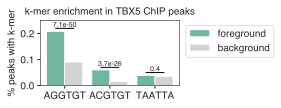

In [107]:
fig = plt.figure(figsize=(2.5, 1.2))

pal = {"foreground": sns.color_palette("Set2")[0], "background": "lightgrey"}

ax = sns.barplot(data=motif_m[~motif_m["variable"].str.startswith("no")],
                 x="variable", y="perc", hue="index", palette=pal)
plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_ylabel("% peaks with k-mer")
ax.set_ylim((0, 0.25))
ax.set_title("k-mer enrichment in TBX5 ChIP peaks")
ax.set_xlabel("")

# annotate p-values
i = 0
for tab, y in zip([motif_tab, sp_motif_tab, hd_tab], [0.22, 0.07, 0.05]):
    pval = fisher_exact(tab)
    
    ax.plot([i-0.2, i+0.2], [y, y], color="black", linewidth=1)
    
    p = fisher_exact(tab)[1]
    if p < 1e-6:
        s = "{:.1e}".format(p)
    else:
        s = np.round(p, 2)
    
    ax.text(i, y, s, ha="center", va="bottom", fontsize=7)
    i += 1
    
fig.savefig("../../../../figures/TBX5_chip_enrichment.pdf", dpi="figure", bbox_inches="tight")

## 7. QC on the scRNA-seq Joung data: effect sizes across isoforms

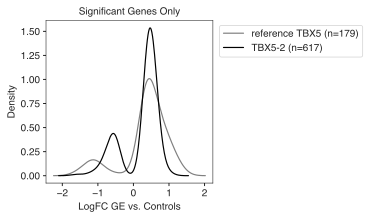

In [44]:
fig = plt.figure(figsize=(3, 3))

ax = sns.distplot(joung_ref["LogFold"], label="reference TBX5 (n=%s)" % len(joung_ref), color="grey", hist=False)
sns.distplot(joung_alt["LogFold"], label="TBX5-2 (n=%s)" % len(joung_alt), color="black", hist=False, ax=ax)
ax.set_xlabel("LogFC GE vs. Controls")
ax.set_ylabel("Density")
ax.set_title("Significant Genes Only")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

## 8. classify ChIP peaks by their closest protein-coding TSS gene

is this gene affected in joung et al o/ex?

In [45]:
closest_tss["id"] = closest_tss["id"] + "::" + closest_tss["chr"] + ":" + closest_tss["start"].astype(str) + "-" + closest_tss["end"].astype(str)
closest_tss.id.iloc[0]

'ID=SRX1815017;Name=TBX5%20(@%20iPSC%20derived%20cardiac%20cells);Title=GSM2183992:%20TBX5%3B%20Homo%20sapiens%3B%20ChIP-Seq;Cell%20group=Pluripotent%20stem%20cell;<br>source_name=blood;cell%20type=hiPSCs-CMs;Stage=day%2030;replicate=1;chip-seq%20antibody=Sigma,%20SAB1411331;::chr1:629629-630029'

In [46]:
chip_filt = chip_filt.merge(closest_tss[["id", "tx_tss", "dist"]], on="id", how="left")

In [47]:
chip_filt["gene_name"] = chip_filt["tx_tss"].str[:-4]

In [93]:
chip_filt["joung_ref"] = chip_filt["gene_name"].isin(joung_ref["Symbol"])
chip_filt["joung_alt"] = chip_filt["gene_name"].isin(joung_alt["Symbol"])

In [94]:
def classify_gene(row):
    if row.joung_ref and row.joung_alt:
        return "both"
    elif row.joung_ref:
        return "ref. only"
    elif row.joung_alt:
        return "alt. only"
    else:
        return "neither"
    
chip_filt["joung_status"] = chip_filt.apply(classify_gene, axis=1)
chip_filt["joung_status"].value_counts()

neither      4267
alt. only     327
ref. only      41
both           13
Name: joung_status, dtype: int64

In [95]:
enrichment_joung_tabs = {}
enrichment_joung_perc = pd.DataFrame()

for status in ["both", "ref. only", "alt. only"]:
    
    fg = chip_filt[chip_filt["joung_status"] == status]
    bg = genre[genre["peak_id"].isin(list(fg["peak_id"]))]
    
    motif_res = {}
    perc_res = {}
    for motif_col, kmer in zip(["has_motif", "has_sp_motif", "has_hd"],
                                [motif, sp_motif, "TAATTA"]):
        
        n_m_fg = len(fg[fg[motif_col] == 1])
        n_nom_fg = len(fg[fg[motif_col] == 0])
        
        n_m_bg = len(bg[bg[motif_col] == 1])
        n_nom_bg = len(bg[bg[motif_col] == 0])
        
        tab = np.zeros((2, 2))
        tab[0, 0] = n_m_fg
        tab[0, 1] = n_nom_fg
        tab[1, 0] = n_m_bg
        tab[1, 1] = n_nom_bg
    
        motif_res[kmer] = fisher_exact(tab)
        
        perc_fg = n_m_fg/(n_m_fg+n_nom_fg)
        perc_bg = n_m_bg/(n_m_bg+n_nom_bg)
        
        perc_res[kmer] = {"perc_fg": perc_fg, "perc_bg": perc_bg}
    
    enrichment_joung_tabs[status] = motif_res
    
    df = pd.DataFrame.from_dict(perc_res)
    df["status"] = status
    enrichment_joung_perc = enrichment_joung_perc.append(df)

In [96]:
enrichment_joung_perc.reset_index(inplace=True)

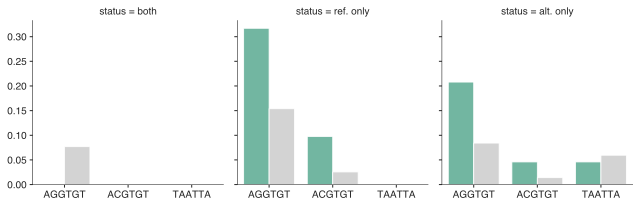

In [97]:
to_plot = pd.melt(enrichment_joung_perc, id_vars=["status", "index"])

g = sns.FacetGrid(to_plot, col="status", margin_titles=True)
g.map_dataframe(sns.barplot, x="variable", hue="index", y="value",
                palette={"perc_fg": sns.color_palette("Set2")[0],
                         "perc_bg": "lightgrey"})

In [98]:
enrichment_joung_perc

,index,AGGTGT,ACGTGT,TAATTA,status
0,perc_fg,0.000000,0.000000,0.000000,both
1,perc_bg,0.076923,0.000000,0.000000,both
2,perc_fg,0.317073,0.097561,0.000000,ref. only
3,perc_bg,0.153846,0.025641,0.000000,ref. only
4,perc_fg,0.207951,0.045872,0.045872,alt. only
5,perc_bg,0.084211,0.014035,0.059649,alt. only


In [99]:
0.317/0.098

3.2346938775510203

In [100]:
0.208/0.046

4.521739130434782